## 1. Build the Model

In [1]:
import pyterrier as pt
import pandas as pd
import os

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
df = pd.read_csv('steam.csv')
df['docno'] = (df['Unnamed: 0']+1).astype(str)
df['release_date'] = df.release_date.astype(str)
df['genres'] = df.label.str.replace('\n',',').astype(str)
df['description'] = df.description.astype(str)
df['comments'] = df.comments.str.replace('\n',',').astype(str)
df['year'] = df['release_date'].str[-4:].astype(str)
df['num_reviews'] = df.num_reviews.astype(str)
df['positive_review_rate'] = df.positive_review_rate.str.replace('%','').astype(str)
df['price'] = df.price.astype(str)
df['name'] = df.name.astype(str)
df.head()

,Unnamed: 0,Link,ID,detail,name,price,label,description,recent_evalution,release_date,Recent_quantity_praise_rate,developers,comments,num_reviews,positive_review_rate,docno,genres,year
0,0,https://store.steampowered.com/app/1336490/,1336490,"('Against the Storm', '$39.98', 'Strategy\nBas...",Against the Storm,39.98,Strategy\nBase Building\nSimulation\nCity Buil...,A dark fantasy city builder where you must reb...,Overwhelmingly Positive,"Nov 1, 2022",97% of the 639 user reviews for this game are ...,Eremite Games,If you're anything like me you love city buil...,639,97,1,"Strategy,Base Building,Simulation,City Builder...",2022
1,1,https://store.steampowered.com/app/1599660/,1599660,"('Sackboy™: A Big Adventure', '$59.99', 'Adven...",Sackboy™: A Big Adventure,59.99,Adventure\nMultiplayer\n3D\nPlatformer\nFamily...,PERFECTLY CRAFTED FOR PCPlayStation® icon Sack...,Very Positive,"Oct 27, 2022",89% of the 247 user reviews for this game are ...,Sumo Digital,"Id pay double for LBP2,having a lot of fun wit...",247,89,2,"Adventure,Multiplayer,3D,Platformer,Family Fri...",2022
2,2,https://store.steampowered.com/app/1730590/,1730590,"('The Entropy Centre', '$29.98', 'Adventure\nP...",The Entropy Centre,29.98,Adventure\nPuzzle\nSci-fi\nStory Rich\nFirst-P...,Think in reverse. Outsmart the impossible. A m...,Very Positive,"Nov 3, 2022",94% of the 224 user reviews for this game are ...,Stubby Games,https://youtu.be/YAQstN36ULY My Opinion on The...,224,94,3,"Adventure,Puzzle,Sci-fi,Story Rich,First-Perso...",2022
3,3,https://store.steampowered.com/app/1665190/,1665190,"('Monster Prom 3: Monster Roadtrip', '$11.96',...",Monster Prom 3: Monster Roadtrip,11.96,Comedy\nVisual Novel\nMultiplayer\nLGBTQ+\nCho...,Embark on a road trip like no other in this co...,Overwhelmingly Positive,"Oct 21, 2022",99% of the 915 user reviews for this game are ...,Beautiful Glitch,"10/10 would frame a child again lol,Game of th...",915,99,4,"Comedy,Visual Novel,Multiplayer,LGBTQ+,Choices...",2022
4,4,https://store.steampowered.com/app/347800/,347800,"('Ghost Song', '$19.99', 'Metroidvania\nSci-fi...",Ghost Song,19.99,Metroidvania\nSci-fi\n2D\nAction\nPlatformer\n...,"On the desolate moon of Lorian, a long-dormant...",Very Positive,"Nov 3, 2022",88% of the 179 user reviews for this game are ...,Old Moon,I just didn't enjoy this game. The combat fel...,179,88,5,"Metroidvania,Sci-fi,2D,Action,Platformer,Atmos...",2022


In [4]:
pd_indexer = pt.DFIndexer("./pd_index", overwrite=True, blocks=True)
indexref = pd_indexer.index(df["description"],df["docno"], 
                            df["release_date"], df["name"], df["genres"], 
                            df["comments"], df["num_reviews"],
                            df["positive_review_rate"], df["price"] )

22:28:22.319 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (296) - further warnings are suppressed
22:28:28.238 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 114 empty documents


In [5]:
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 10330
Number of terms: 15247
Number of postings: 182765
Number of fields: 0
Number of tokens: 195418
Field names: []
Positions:   true



In [6]:
queries = pd.read_csv('SI650_query.csv') 
queries['qid'] = queries.qid.astype('str')
queries.head()

,qid,query
0,1,An action game
1,2,A text-based interactive game
2,3,A horror game with bloody scenes
3,4,A game in which players act as a city builder ...
4,5,A game with pixel puzzles to solve


In [9]:
# there are some characters in the query have a special meaning in the Terrier query language. 
# strip them out using the Tokeniser
def strip_markup(text):
    tokeniser = pt.autoclass("org.terrier.indexing.tokenisation.Tokeniser").getTokeniser()
    return " ".join(tokeniser.getTokens(text))

queries =  pt.apply.query(lambda r: strip_markup(r.query))(queries)
queries = queries[['query','qid']]

In [10]:
# query relevance
br = pt.BatchRetrieve(index, wmodel="BM25")

In [11]:
qrels = pd.read_csv('qrels.csv', index_col = False).drop(columns = ['Unnamed: 0']).rename(columns = {'rel_score':'label'})
qrels['qid'] = qrels.qid.astype(str)
qrels['docno'] = qrels.docno.astype(str)
qrels.head()

,qid,docno,label
0,1,3069,5
1,1,7248,5
2,1,2974,5
3,1,2673,5
4,1,3809,5


In [12]:
tf = pt.BatchRetrieve(index, wmodel="TF")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
inb2 = pt.BatchRetrieve(index, wmodel="InB2")
inb2_exp = pt.BatchRetrieve(index, wmodel="In_expB2")
br = pt.BatchRetrieve(index)
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)
pipe1 = sdm >> bm25
pipe2 = bm25 >> qe >> bm25

In [13]:
RANK_CUTOFF = 100
SEED=42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(queries, test_size=9, random_state=SEED)
train_topics, valid_topics = train_test_split(tr_va_topics, test_size=3, random_state=SEED)

In [14]:
pt.Experiment(
    [br,bm25],
    test_topics,
    qrels,
    names=['br','BM25'],
    eval_metrics=["map", "ndcg", 'ndcg_cut_100', "P_30", "recall_30", 'mrt']
)

,name,map,ndcg,ndcg_cut_100,P_30,recall_30,mrt
0,br,0.226741,0.747039,0.436866,0.440741,0.120202,510.003147
1,BM25,0.291618,0.818914,0.496983,0.659259,0.179798,473.011647


In [15]:
ltr_feats_0 = (bm25) >> pt.text.get_text(index, ["release_date", "name", "genres", "comments","num_reviews","positive_review_rate","price"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["positive_review_rate"] is None else int(row["positive_review_rate"])))
    ** # score of genres
    (pt.text.scorer(body_attr="genres", wmodel='BM25') ) 
    ** # score of name
    (pt.text.scorer(body_attr="name", wmodel='BM25') ) 
    ** # score of comments
    (pt.text.scorer(body_attr="comments", wmodel='BM25'))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

fnames=["BM25", "SDM", 'rating',  "genres", "name", "comments","CoordinateMatch"]

## 2. Evaluate the model

In [15]:
feature_eval = pt.Experiment(
    [ltr_feats_0 >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_100", "P_30", "recall_30", "mrt"])
# feature_eval.to_csv("feature_eval.csv")
# files.download('feature_eval.csv')
     

16:36:10.432 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
16:36:12.373 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
16:36:29.634 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
16:37:27.775 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

In [16]:
feature_eval

,name,map,ndcg,ndcg_cut_100,P_30,recall_30,mrt
0,BM25,0.291618,0.818914,0.496983,0.659259,0.179798,8861.165312
1,SDM,0.290023,0.817816,0.495886,0.659259,0.179798,8455.562886
2,rating,0.107021,0.522647,0.082195,0.085185,0.023232,8405.444352
3,genres,0.119874,0.544184,0.130280,0.140741,0.038384,8476.910282
4,name,0.124608,0.583666,0.160930,0.177778,0.048485,7752.727881
5,comments,0.137298,0.569858,0.171287,0.151852,0.041414,7796.733214
6,CoordinateMatch,0.139160,0.624982,0.235174,0.207407,0.056566,8192.939995


In [15]:
ltr_feats_1 = (bm25) >> pt.text.get_text(index, ["release_date", "name", "genres", "comments","num_reviews","positive_review_rate","price"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["positive_review_rate"] is None else int(row["positive_review_rate"])))
    ** # score of name
    (pt.text.scorer(body_attr="name", wmodel='BM25') ) 
    ** # score of comments
    (pt.text.scorer(body_attr="comments", wmodel='BM25'))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [16]:
ltr_feats_2 = (bm25) >> pt.text.get_text(index, ["release_date", "name", "genres", "comments","num_reviews","positive_review_rate","price"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of genres
    (pt.text.scorer(body_attr="genres", wmodel='BM25') ) 
    ** # score of name
    (pt.text.scorer(body_attr="name", wmodel='BM25') ) 
    ** # score of comments
    (pt.text.scorer(body_attr="comments", wmodel='BM25'))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [17]:
ltr_feats_3 = (bm25) >> pt.text.get_text(index, ["release_date", "name", "genres", "comments","num_reviews","positive_review_rate","price"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of name
    (pt.text.scorer(body_attr="name", wmodel='BM25') ) 
    ** # score of comments
    (pt.text.scorer(body_attr="comments", wmodel='BM25'))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [18]:
ltr_feats_4 = (bm25) >> pt.text.get_text(index, ["release_date", "name", "genres", "comments","num_reviews","positive_review_rate","price"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["positive_review_rate"] is None else int(row["positive_review_rate"])))
    ** # score of name
    (pt.text.scorer(body_attr="name", wmodel='BM25') ) 
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [19]:
ltr_feats_5 = (bm25) >> pt.text.get_text(index, ["release_date", "name", "genres", "comments","num_reviews","positive_review_rate","price"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of comments
    (pt.text.scorer(body_attr="comments", wmodel='BM25'))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [20]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

qrels['label'] = qrels.label.astype(float)

ca_pipe0 = ltr_feats_0 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe0.fit(train_topics, qrels)
ca_pipe1 = ltr_feats_1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe1.fit(train_topics, qrels)
ca_pipe2 = ltr_feats_2 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe2.fit(train_topics, qrels)
ca_pipe3 = ltr_feats_3 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe3.fit(train_topics, qrels)
ca_pipe4 = ltr_feats_4 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe4.fit(train_topics, qrels)
ca_pipe5 = ltr_feats_5 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe5.fit(train_topics, qrels)
# ca_pipe6 = ltr_feats_6 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
# %time ca_pipe6.fit(train_topics, qrels)
# ca_pipe7 = ltr_feats_7 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
# %time ca_pipe7.fit(train_topics, qrels)

17:27:33.265 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:27:36.195 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:28:03.906 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5..

---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   1|5               |   -0.000|    0.879
   1|5               |    0.000|    0.879
   2|5               |   -0.000|    0.878
   3|0               |    0.134|    0.877
   2|5               |   -0.000|    0.878
   3|0               |    0.268|    0.877
   3|0               |    0.536|    0.878
---------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
   3|6               |    0.000|    0.878
   2|5               |    0.000|    0.878
   3|6               |    0.000|    0.878
   3|6               |   -0.000|    0.878
   3|6               |   -0.001|    0.878
   3|6               |   -0.002|    0.878
   3|6               |   -0.007|    0.878
   3|6               |   -0.014|    0.878
   3

17:30:49.432 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:31:18.562 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------

   4|2               |   -0.000|    0.878
   2|1               |   -0.001|    0.878
   2|1               |   -0.007|    0.878
   2|1               |   -0.014|    0.878
   2|1               |   -0.027|    0.878
   2|1               |   -0.054|    0.878
   2|1               |   -0.430|    0.879
   0|5               |    0.050|    0.533
   0|5               |    0.150|    0.536
   0|5               |    0.350|    0.543
   0|5               |    0.750|    0.555
   0|5               |    1.550|    0.567
   0|5               |    3.150|    0.601
   1|3               |    0.000|    0.879
   0|5               |    6.350|    0.648
   0|5               |   12.750|    0.654
   0|5               |   25.550|    0.654
   1|3               |    0.005|    0.879
   0|5               |104857.550|    0.654
---------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
   2|5            

   1|5               |    0.000|    0.544
   2|5               |    0.000|    0.754
   4|5               |    0.000|    0.651
   2|4               |    0.000|    0.841
   4|3               |    0.000|    0.660
   1|0               |    0.024|    0.545
   3|5               |    0.266|    0.557
   2|0               |    0.642|    0.847
   4|0               |    0.317|    0.687
   1|0               |    0.026|    0.546
   0|2               |    0.284|    0.418
   3|5               |    0.366|    0.561
   2|0               |    0.742|    0.857
   1|0               |    0.031|    0.549
   4|0               |    0.417|    0.726
   0|2               |    0.384|    0.425
   3|5               |    0.566|    0.573
   2|0               |    0.942|    0.867
   4|0               |    0.617|    0.782
   1|0               |    0.040|    0.554
   0|2               |    0.584|    0.437
   3|5               |    0.966|    0.617
   2|0               |    1.342|    0.873
   4|0               |    1.017|  

   0|5               |    0.750|    0.558
---------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
   0|5               |    1.550|    0.579
   2|5               |    0.000|    0.879
   0|5               |    3.150|    0.620
   2|5               |   -0.050|    0.880
   2|5               |   -0.150|    0.882
   0|5               |    6.350|    0.656
   4|2               |    0.001|    0.880
   4|2               |    0.001|    0.880
   1|4               |   -0.000|    0.879
   1|4               |   -0.000|    0.879
   1|4               |   -0.000|    0.879
   1|4               |   -0.000|    0.879
   2|4               |    0.000|    0.882
   4|2               |    0.001|    0.880
   4|2               |    0.001|    0.880
   0|0               |    0.050|    0.709
---------------------------
Shuffle features and optimize!
----------------------------------------
   

   4|1               |   -0.013|    0.878
   2|1               |    0.000|    0.849
   0|3               |-4722.486|    0.442
   1|1               |   -0.001|    0.878
   0|3               |-9444.978|    0.442
   4|1               |   -0.050|    0.878
   1|1               |   -0.014|    0.878
   4|1               |   -0.200|    0.878
   4|1               |   -0.399|    0.878
   1|1               |   -0.030|    0.878
   4|1               |   -0.799|    0.878
   1|1               |   -0.062|    0.878
   1|1               |   -0.258|    0.878
   0|2               |   -0.000|    0.442
   1|1               |   -0.519|    0.878
   0|2               |   -0.000|    0.442
   0|2               |   -0.000|    0.442
   0|2               |   -0.000|    0.442
   0|2               |   -0.001|    0.442
   3|0               |    0.150|    0.877
   3|0               |    0.350|    0.877
   3|0               |    0.750|    0.877
   3|0               |    1.550|    0.878
   3|0               |    3.150|  

   0|3               |    0.000|    0.880
   0|3               |    0.000|    0.880
   3|0               |    0.530|    0.882
   0|2               |    0.000|    0.880
   4|4               |   -0.058|    0.881
   0|4               |    0.000|    0.880
   0|4               |   -0.000|    0.880
   0|4               |   -0.005|    0.880
   0|4               |   -0.010|    0.880
   0|4               |   -0.020|    0.881
   0|4               |   -0.041|    0.881
   0|4               |   -0.082|    0.881
   1|2               |    0.003|    0.882
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |    0.597|    0.882
   4|3               |    0.000|    0.881
   1|1               |   -0.221|    0.882
   0|4               |   -0.083|    0.882
   0|3               |    0.000|    0.882
   0|3               |    0.000|    0.882
   0|3             

   0|0               |    0.114|    0.576
   0|0               |    0.228|    0.604
   0|0               |    0.457|    0.647
   0|0               |    0.915|    0.755
   0|0               |    1.830|    0.824
   0|0               |    3.659|    0.860
   0|0               |    7.319|    0.874
   0|0               |   14.638|    0.878
   0|0               |   29.277|    0.878
   0|0               |   58.555|    0.878
   0|0               |  234.220|    0.878
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   2|1               |    0.000|    0.882
   0|4               |   -0.000|    0.878
   0|4               |   -0.000|    0.878
   0|4               |   -0.019|    0.878
   0|4               |   -0.038|    0.879
   0|4               |   -0.076|    0.879
   0|4               |   -0.152|    0.880
   0|4               |   -0.303|    0.882
   0|4             

   0|2               |   -0.315|    0.425
   4|1               |   -0.001|    0.878
   4|1               |   -0.002|    0.878
   0|2               |   -0.630|    0.426
   0|0               |   -0.000|    0.426
   4|1               |   -0.006|    0.878
   4|1               |   -0.013|    0.878
   1|1               |   -0.000|    0.878
   0|0               |   -0.000|    0.426
   1|1               |   -0.000|    0.878
   4|1               |   -0.050|    0.878
   1|1               |   -0.001|    0.878
   4|1               |   -0.200|    0.878
   4|1               |   -0.400|    0.878
   1|1               |   -0.016|    0.878
   4|1               |   -0.799|    0.879
   1|1               |   -0.066|    0.878
   1|1               |   -0.264|    0.878
   1|1               |   -0.529|    0.879
---------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
   2|3             

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
qrels
rf_pipe = ltr_feats_0 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, qrels)
     

17:45:27.792 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:45:30.759 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:45:53.973 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.9s


CPU times: user 2min 20s, sys: 46 s, total: 3min 6s
Wall time: 3min 7s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    9.9s finished


In [22]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[100],
    ndcg_at=[100],
    eval_at=[100],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=500,
    early_stopping_rounds=40
)

lmart_pipe0 = ltr_feats_0 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
%time lmart_pipe0.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe1 = ltr_feats_1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe1.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe2 = ltr_feats_2 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe2.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe3 = ltr_feats_3 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe3.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe4 = ltr_feats_4 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe4.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe5 = ltr_feats_5 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe5.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe6 = ltr_feats_6 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe6.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe7 = ltr_feats_7 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe7.fit(train_topics, qrels, valid_topics, qrels)

17:48:48.293 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:48:51.475 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:49:26.116 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:49:55.115 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=40, early_stopping_rounds=40 will be ignored. Current value: early_stopping_round=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 27936, number of used features: 7

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's ndcg@10: 0.932506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's ndcg@10: 0.953713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's ndcg@10: 0.931628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's ndcg@10: 0.932506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's ndcg@10: 0.932506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's ndcg@10: 0.932506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's ndcg@10: 0.932506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's ndcg@10: 0.932506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's ndcg@10: 0.963318
[LightGBM] [Warning] No

In [23]:
qrels['label'] = qrels.label.astype(int)
pipe1 = sdm >> bm25
pipe2 = bm25 >> qe >> bm25

pt.Experiment(
    [br, bm25, ca_pipe0,ca_pipe1,ca_pipe2,ca_pipe3,ca_pipe4,ca_pipe5,lmart_pipe0, rf_pipe, pipe1, pipe2], 
    test_topics, 
    qrels, 
    names=["BR", "BM25", "BM25+CA0","BM25+CA1","BM25+CA2","BM25+CA3","BM25+CA4","BM25+CA5", "BM25+LMART", "BM25+RF", "Pipeline 1", "Pipeline 2"], 
    eval_metrics=["map", "ndcg", "ndcg_cut_100", "P_30", "recall_30", "mrt"])
# table.to_csv("evaluation.csv")

17:50:58.712 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:51:00.349 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:51:19.504 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:52:07.439 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.2s finished


,name,map,ndcg,ndcg_cut_100,P_30,recall_30,mrt
0,BR,0.226741,0.747039,0.436866,0.440741,0.120202,511.480017
1,BM25,0.291618,0.818914,0.496983,0.659259,0.179798,471.900098
2,BM25+CA0,0.297455,0.822675,0.493064,0.685185,0.186869,7760.437081
3,BM25+CA1,0.296558,0.821934,0.492701,0.688889,0.187879,7002.807582
4,BM25+CA2,0.296543,0.821910,0.495373,0.692593,0.188889,7435.492976
5,BM25+CA3,0.296098,0.821663,0.493109,0.677778,0.184848,7031.160596
6,BM25+CA4,0.295084,0.821103,0.494452,0.677778,0.184848,5254.140409
7,BM25+CA5,0.296470,0.821871,0.495167,0.685185,0.186869,7210.882981
8,BM25+LMART,0.273739,0.796204,0.482834,0.533333,0.145455,7679.212576
9,BM25+RF,0.248983,0.743647,0.405153,0.451852,0.123232,7524.310324


/var/folders/10/lx3rh6q956qc768glw5ktj600000gn/T/ipykernel_11239/1704206419.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


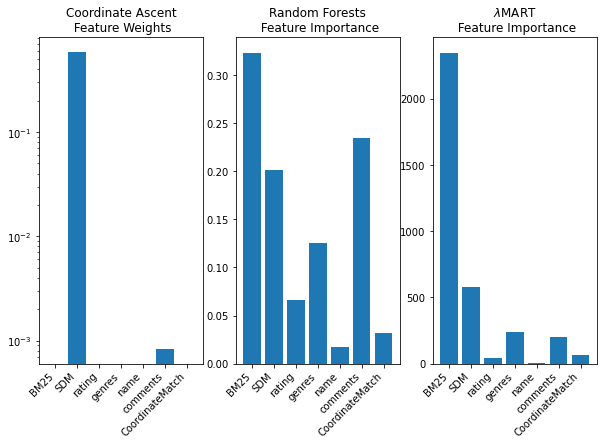

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe0[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()

## Run the IR system

In [23]:
user_query = input("Please enter the description of the game you want to search: ")
while True:
    result = ltr_feats_0.search(user_query) 
    print(result.iloc[0:10, 7])
    user_query = input("enter 'stop' or another description of the game you want to search: ")
    if(user_query == 'stop'): 
        break

Please enter the description of the game you want to search: action game
22:59:26.985 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:59:27.323 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:59:29.986 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
0                       SUPER UFO FIGHTER
1                         Critical Dama